## Backtesting Value at Risk and Median Shortfall with Python

In [1]:
def value_at_risk(returns, confidence_level):
    """
    Compute the Value-at-Risk metric of returns at confidence_level
    :param returns: DataFrame
    :param confidence_level: float
    :return: float
    """

    # Calculate the highest return in the lowest quantile (based on confidence level)
    var = returns.quantile(q=confidence_level, interpolation="higher")
    return var

def median_shortfall(returns, confidence_level):
    """
    Compute the Median Shortfall metric of returns at confidence_level
    :param returns: DataFrame
    :param confidence_level: float
    :return: float
    """

    # Calculate the VaR of the returns
    var = value_at_risk(returns, confidence_level)

    # Find all returns in the worst quantile
    worst_returns = returns[returns.lt(var)]

    # Calculate median of all the worst returns
    median_shortfall = worst_returns.median()

    return median_shortfall

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")

# Credit risk regimes
start = '2006-01-01'
end = '2009-01-01'

# List of assets
assets = ['^GSPC', 'BRK-B', '^DJI', '^RUT']

# Downloading the data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
ret = data.pct_change(1).dropna()

ret.head()

[*********************100%***********************]  4 of 4 completed


,^GSPC,BRK-B,^DJI,^RUT
Date,,,,
2006-01-04,0.000675,0.003018,0.003673,0.007602
2006-01-05,-0.002359,0.000184,0.000016,0.003656
2006-01-06,0.003378,0.007090,0.009399,0.011015
2006-01-09,0.003030,0.004799,0.003656,0.009794
2006-01-10,-0.003021,-0.000029,-0.000357,0.006726


In [3]:
n = ret.shape[0]

Risk_hist = {}
for i in assets:
    Risk_hist[i] = {'VaR':[], 'MS':[]}

window = 250 
confidence_level = 0.01

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        var_value = Risk_hist[j]['VaR'].append(value_at_risk(X, confidence_level))
        ms_value = Risk_hist[j]['MS'].append(median_shortfall(X, confidence_level))
        
        if var_value is not None and ret[j].iloc[i] < var_value:
            Risk_hist[j]['VaR_Exceptions'] += 1
        
        if ms_value is not None and ret[j].iloc[i] < ms_value:
            Risk_hist[j]['MS_Exceptions'] += 1
            
for i in assets:
    Risk_hist[i] = pd.DataFrame(Risk_hist[i], index=ret.index[window:])

[]

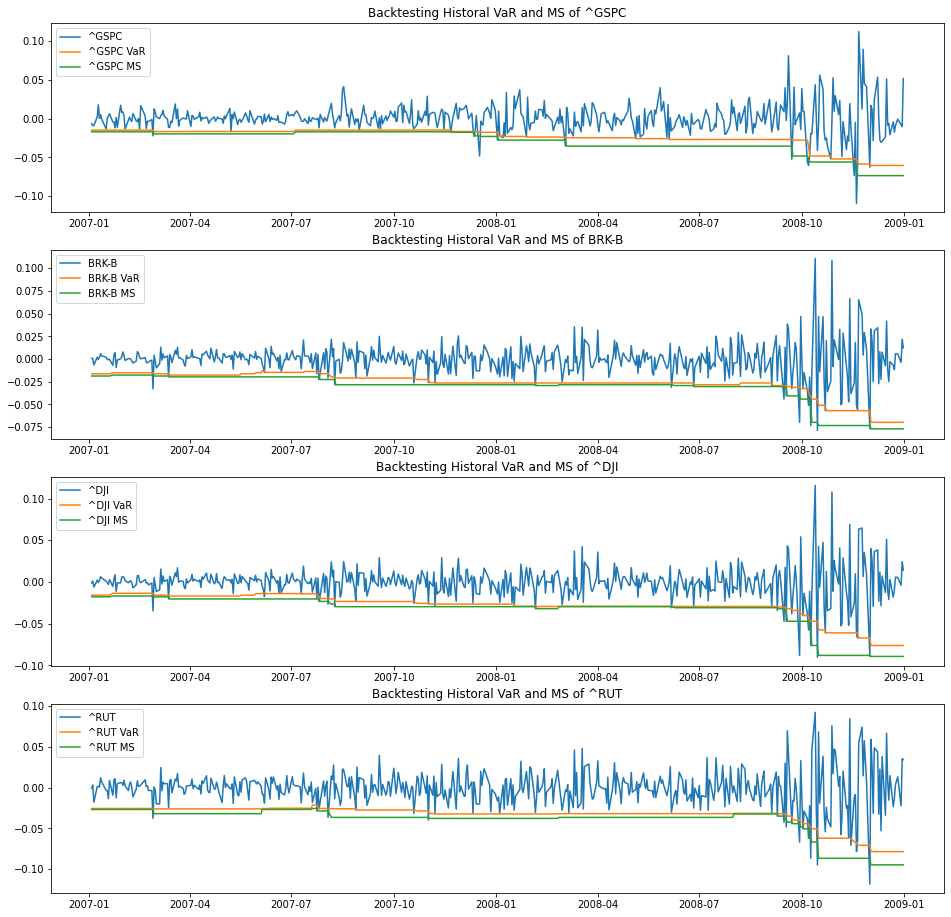

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_hist[assets[i]]['VaR'], label=assets[i] + ' VaR')
    ax[i].plot(Risk_hist[assets[i]]['MS'], label=assets[i] + ' MS')
    ax[i].legend()
    ax[i].set_title('Backtesting Historal VaR and MS of ' + assets[i])

plt.plot()

In [5]:
for i in range(len(assets)):
    varexceptions = (ret[assets[i]].iloc[window:] < Risk_hist[assets[i]]['VaR']).sum()
    msexceptions = (ret[assets[i]].iloc[window:] < Risk_hist[assets[i]]['MS']).sum()
    print(f"For {assets[i]}: Number of VaR Exceptions: {varexceptions}")
    print(f"For {assets[i]}: Number of MS Exceptions: {msexceptions}")


For ^GSPC: Number of VaR Exceptions: 18
For ^GSPC: Number of MS Exceptions: 11
For BRK-B: Number of VaR Exceptions: 25
For BRK-B: Number of MS Exceptions: 14
For ^DJI: Number of VaR Exceptions: 29
For ^DJI: Number of MS Exceptions: 15
For ^RUT: Number of VaR Exceptions: 20
For ^RUT: Number of MS Exceptions: 14


##### Kupiec (1995) test

Proportion of failure test for backtesting VaR and MS

In [6]:
def bern_test(p,v):
    lv = len(v) #trading days
    sv = sum(v) #number of failures
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    bl = np.log(sv/lv)*sv + np.log(1-(sv/lv))*(lv-sv)
    return (-2*(al-bl))

#### Christofferson (1998)

In [7]:
def ind_test(v):
    T = len(v)
    J = np.full([T,4], 0)
    for i in range(1,len(v)-1):
        J[i,0] = (v[i-1] == 0) & (v[i] == 0)
        J[i,1] = (v[i-1] == 0) & (v[i] == 1)
        J[i,2] = (v[i-1] == 1) & (v[i] == 0)
        J[i,3] = (v[i-1] == 1) & (v[i] == 1)
    v_00 = sum(J[:,0])
    v_01 = sum(J[:,1])
    v_10 = sum(J[:,2])
    v_11 = sum(J[:,3])
    p_00=v_00/(v_00+v_01)
    p_01=v_01/(v_00+v_01)
    p_10=v_10/(v_10+v_11)
    p_11=v_11/(v_10+v_11)
    hat_p = (v_01+v_11)/(v_00+v_01+v_10+v_11)
    al = np.log(1-hat_p)*(v_00+v_10) + np.log(hat_p)*(v_01+v_11)
    bl = np.log(p_00)*v_00 + np.log(p_01)*v_01 + np.log(p_10)*v_10 + np.log(p_11)*v_11
    return (-2*(al-bl))

In [8]:
keys = ['Failure Ratio VaR','Failure Ratio MS','Bernoulli Test VaR stat','Bernoulli Test VaR p-value',
        'Bernoulli Test MS stat','Bernoulli Test MS p-value','Independent Test VaR stat','Independent Test VaR p-value',
        'Independent Test MS stat', 'Independent Test MS p-value']

In [9]:
Stats_hist = {}

for i in assets:
    Stats_hist[i] = {}
    for j in keys:
        Stats_hist[i][j] = []


In [10]:
for i in Stats_hist.keys():
    for j in Risk_hist[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_hist[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_hist[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(confidence_level, v)
        ind = ind_test(v)
        Stats_hist[i]['Failure Ratio ' + j].append(H/T)
        Stats_hist[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_hist[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_hist[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_hist[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_hist[i] = pd.DataFrame(Stats_hist[i]).T
    Stats_hist[i].columns = [i]
    a = pd.concat([a, Stats_hist[i]], axis=1)
    
Stats_hist = a
display(Stats_hist)  

,^GSPC,BRK-B,^DJI,^RUT
Failure Ratio VaR,0.035714,0.049603,0.057540,0.039683
Failure Ratio MS,0.021825,0.027778,0.029762,0.027778
Bernoulli Test VaR stat,20.246340,40.962820,54.743030,25.666130
Bernoulli Test VaR p-value,0.000010,0.000000,0.000000,0.000000
Bernoulli Test MS stat,5.322240,10.848100,12.999480,10.848100
Bernoulli Test MS p-value,0.021050,0.000990,0.000310,0.000990
Independent Test VaR stat,2.035970,0.056910,0.352750,NaN
Independent Test VaR p-value,0.153620,0.811450,0.552560,NaN
Independent Test MS stat,1.438580,NaN,NaN,NaN
Independent Test MS p-value,0.230370,NaN,NaN,NaN
